In [1]:
#VERSION INFO
import sys
import sklearn
import tensorflow 
import keras
import platform

print (sys.version)
print("Python Version",  platform.python_version())
print ("Tensorflow Version:", tensorflow.__version__)
print ("sklearn Version",sklearn.__version__)
print ("Keras Version",keras.__version__)

3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]
Python Version 3.5.2
Tensorflow Version: 1.12.0
sklearn Version 0.20.1
Keras Version 2.2.4


Using TensorFlow backend.


In [2]:
#Misc
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re

#Sci-kit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

In [3]:
#LOADING DATA
training_data = "offenseval-training-v1.tsv"
data = pd.read_table(training_data)
print(data.head())

      id                                              tweet subtask_a  \
0  86426  @USER She should ask a few native Americans wh...       OFF   
1  90194  @USER @USER Go home you’re drunk!!! @USER #MAG...       OFF   
2  16820  Amazon is investigating Chinese employees who ...       NOT   
3  62688  @USER Someone should'veTaken" this piece of sh...       OFF   
4  43605  @USER @USER Obama wanted liberals &amp; illega...       NOT   

  subtask_b subtask_c  
0       UNT       NaN  
1       TIN       IND  
2       NaN       NaN  
3       UNT       NaN  
4       NaN       NaN  


In [4]:
#PREPROCESSING CELL

#REMOVING OTHER SUBTASKS
data = data[['tweet','subtask_a']]

#FACTORIZING LABELS
data['label']=data['subtask_a'].factorize()[0]
data = data[['tweet','label']]

#LOWERCASING, STEMMING AND REMOVING STOP WORDS
def clean_text(tweet):
    stop_words = stopwords.words("english")
    stemmer = PorterStemmer()
    filtered_sentence=[]
    tweet = tweet.lower().split()
    filtered_sentence = [stemmer.stem(w) for w in tweet if w not in stop_words]
    filtered_sentence = " ".join(filtered_sentence)
    return filtered_sentence
    
data['tweet'] = data['tweet'].map(lambda x: clean_text(x))
print(data.head())

count0 = 0
count1 = 0
for i in data["label"]:
    if i == 0:
        count0+=1
    else:
        count1+=1
print("Offensive Tweets: ",count0)
print("Non Offensive Tweets: ",count1)

                                               tweet  label
0                  @user ask nativ american take is.      0
1  @user @user go home you’r drunk!!! @user #maga...      0
2  amazon investig chines employe sell intern dat...      1
3  @user someon should'vetaken" piec shit volcano...      0
4  @user @user obama want liber &amp; illeg move ...      1
Offensive Tweets:  4400
Non Offensive Tweets:  8840


In [5]:
#TOKENIZING AND CREATING SEQUENCE 1
vocabulary_size = 30000
max_len = 100
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(data['tweet'])

sequences = tokenizer.texts_to_sequences(data['tweet'])
X = pad_sequences(sequences, maxlen=max_len)
print(X.shape)
y = np.array(data['label'])

(13240, 100)


In [7]:
#GLOBAL VARIABLES
EMBEDDING_DIM = 200
class_weight = {0:1,1:1}
epochs = 10
split = 0.2

In [8]:
#GLOVE WORD EMBEDDINGS
embeddings_index = dict()
f = open('glove.twitter.27B/glove.twitter.27B.200d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocabulary_size, 200))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
print("Embeddings Weight Calculated")

Embeddings Weight Calculated


In [9]:
#CROSS VALIDATION 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, stratify = y)

In [26]:
#MODEL ARCHITECTURE 2
print("Fitting The model")
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, 200, input_length=max_len, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.5))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(200))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Fit train data
hist = model_glove.fit(X_train,
                       y_train,
                       validation_split = split,
                       epochs = epochs,
                       class_weight = class_weight)

Fitting The model
Train on 7944 samples, validate on 1986 samples
Epoch 1/10
7944/7944 [==============================] - 17s 2ms/step - loss: 0.5801 - acc: 0.6956 - val_loss: 0.5314 - val_acc: 0.7356
Epoch 2/10
7944/7944 [==============================] - 15s 2ms/step - loss: 0.5193 - acc: 0.7475 - val_loss: 0.4874 - val_acc: 0.7749
Epoch 3/10
7944/7944 [==============================] - 15s 2ms/step - loss: 0.4912 - acc: 0.7677 - val_loss: 0.4803 - val_acc: 0.7749
Epoch 4/10
7944/7944 [==============================] - 15s 2ms/step - loss: 0.4774 - acc: 0.7784 - val_loss: 0.4750 - val_acc: 0.7825
Epoch 5/10
7944/7944 [==============================] - 15s 2ms/step - loss: 0.4641 - acc: 0.7852 - val_loss: 0.4812 - val_acc: 0.7734
Epoch 6/10
7944/7944 [==============================] - 15s 2ms/step - loss: 0.4452 - acc: 0.7983 - val_loss: 0.4918 - val_acc: 0.7724
Epoch 7/10
7944/7944 [==============================] - 15s 2ms/step - loss: 0.4327 - acc: 0.8027 - val_loss: 0.5084 - val_a

In [27]:
#EVALUATE THE MODEL
from sklearn.metrics import classification_report 
score = model_glove.evaluate(X_test,y_test,batch_size=32,verbose=1)
y_pred = model_glove.predict_classes(X_test, batch_size=32, verbose=0)
conf_mat = confusion_matrix(y_test, y_pred)

#DISPLAYING SCORES
print("Confusion Matrix:")
print(conf_mat)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

print("\nClassification Report: ")
target_names = ["Class {}".format(i) for i in range(2)]
print(classification_report(y_test, y_pred, 
                            target_names=target_names, 
                            digits = 4))
accuracy_sklearn = accuracy_score(y_test, y_pred, 
                                  normalize=True,
                                  sample_weight=None)
print("Sklearn Accuracy: ",accuracy_sklearn)

3310/3310 [==============================] - 2s 582us/step
Confusion Matrix:
[[ 696  404]
 [ 496 1714]]
Test Loss: 0.5398019680443847
Test Accuracy: 0.7280966767551675

Classification Report: 
              precision    recall  f1-score   support

     Class 0     0.5839    0.6327    0.6073      1100
     Class 1     0.8093    0.7756    0.7921      2210

   micro avg     0.7281    0.7281    0.7281      3310
   macro avg     0.6966    0.7041    0.6997      3310
weighted avg     0.7344    0.7281    0.7307      3310

Sklearn Accuracy:  0.7280966767371602


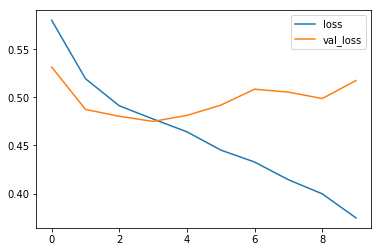

In [28]:
#PLOTS
import matplotlib.pyplot as plt

# plot some data
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

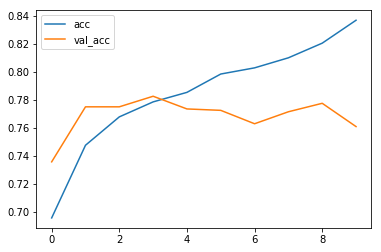

In [29]:
#ACCURACIES
plt.plot(hist.history['acc'], label='acc')
plt.plot(hist.history['val_acc'], label='val_acc')
plt.legend()
plt.show()
